In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import plotly.express as px
import duckdb
import os
from pathlib import Path
from typing import List
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import plotly.express as px

In [4]:
# Afficher le répertoire de travail actuel
import os
print("Répertoire de travail actuel:", os.getcwd())

# Lister les fichiers et dossiers du répertoire parent
print("\nContenu du répertoire parent (..):")
print(os.listdir(".."))

# Lister les fichiers et dossiers deux niveaux au-dessus
print("\nContenu deux niveaux au-dessus (../..):")
try:
    print(os.listdir("../.."))
except FileNotFoundError:
    print("Impossible d'accéder à ce répertoire")

Répertoire de travail actuel: /home/c-enjalbert/Documents/EPSI/MSPR/bloc_2/amazing/ml_ia/item-based-clustering

Contenu du répertoire parent (..):
['Modèle_Pipeline_IA.md', 'item-based-clustering', 'analyse_exploratoire.ipynb', 'clustering']

Contenu deux niveaux au-dessus (../..):
['amazing.duckdb', 'ml_ia', '.amazing.duckdb', 'requirements.txt', '.git', 'Access_token.txt', 'README.md', 'etl', 'data', '.gitignore']


In [5]:
# Essayez différentes approches pour localiser le dossier data
possible_paths = [
    Path("../data"),             # Un niveau au-dessus
    Path("../../data"),          # Deux niveaux au-dessus
    Path("../../../data"),       # Trois niveaux au-dessus
    Path("../../../../data"),    # Quatre niveaux au-dessus
]

for path in possible_paths:
    if path.is_dir():
        print(f"Dossier data trouvé à : {path.resolve()}")
        data_folder = path
        break
else:
    print("Impossible de trouver le dossier data automatiquement")

Dossier data trouvé à : /home/c-enjalbert/Documents/EPSI/MSPR/bloc_2/amazing/data


### Connexion à la DB / Import des Data


In [ ]:
# Store database at project root
DB_NAME = Path("/home/c-enjalbert/Documents/EPSI/MSPR/bloc_2/amazing/amazing.duckdb") 
# Go up one level from current directory to get to project root
data_folder = Path("../..").resolve() / "data"
# For absolute certainty, you could use the absolute path
# data_folder = Path("/home/c-enjalbert/Documents/EPSI/MSPR/bloc_2/amazing/data")
con = duckdb.connect(str(DB_NAME))


IOException: IO Error: Could not set lock on file "/home/c-enjalbert/Documents/EPSI/MSPR/bloc_2/amazing/amazing.duckdb": Conflicting lock is held in /home/c-enjalbert/miniconda3/bin/python3.12 (PID 60375) by user c-enjalbert. See also https://duckdb.org/docs/connect/concurrency

In [ ]:
# 2. Query to list all tables in the database
# DuckDB specific way to list tables
tables_info = con.sql("""
    SELECT table_name
    FROM information_schema.tables
    WHERE table_schema = 'main'
    ORDER BY table_name
""").df()

print(f"Found {len(tables_info)} tables in the database:\n")

if len(tables_info) > 0:
    for i, table_name in enumerate(tables_info['table_name']):
        print(f"{i+1}. {table_name}")
else:
    print("No tables found in the database.")

Found 2 tables in the database:

1. all_events
2. loaded_files


In [ ]:
# 5. Alternative way to show all tables
print("List of all tables using DuckDB's connections.tables():")
con.sql("SHOW TABLES").show()

List of all tables using DuckDB's connections.tables():
┌──────────────┐
│     name     │
│   varchar    │
├──────────────┤
│ all_events   │
│ loaded_files │
└──────────────┘



### Save Tables as DataFrame

In [ ]:
# Get event counts by event_type
print("Event counts by type:")
all_events = con.sql("""
    SELECT 
    *
    FROM all_events
    LIMIT 20000
""")
all_events.show()



Event counts by type:
┌─────────────────────┬────────────┬────────────┬─────────────────────┬─────────────────────────────────────┬──────────┬─────────┬───────────┬──────────────────────────────────────┐
│     event_time      │ event_type │ product_id │     category_id     │            category_code            │  brand   │  price  │  user_id  │             user_session             │
│      timestamp      │  varchar   │  varchar   │       varchar       │               varchar               │ varchar  │ double  │  varchar  │               varchar                │
├─────────────────────┼────────────┼────────────┼─────────────────────┼─────────────────────────────────────┼──────────┼─────────┼───────────┼──────────────────────────────────────┤
│ 2019-10-01 00:00:00 │ view       │ 44600062   │ 2103807459595387724 │ NULL                                │ shiseido │   35.79 │ 541312140 │ 72d76fde-8bb3-4e00-8c23-a032dfed738c │
│ 2019-10-01 00:00:00 │ view       │ 3900821    │ 205301355232677090

In [ ]:
all_events_df = pd.DataFrame(all_events.df())
all_events_df.describe(include="all").T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
event_time,20000,NaN,NaN,NaN,2019-10-01 02:29:27.043549,2019-10-01 00:00:00,2019-10-01 02:28:14.750000,2019-10-01 02:37:18,2019-10-01 02:46:00,2019-10-01 02:54:01,NaN
event_type,20000,3,view,19548,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product_id,20000,7178,1004856,234,NaN,NaN,NaN,NaN,NaN,NaN,NaN
category_id,20000,443,2053013555631882655,5387,NaN,NaN,NaN,NaN,NaN,NaN,NaN
category_code,13412,115,electronics.smartphone,5387,NaN,NaN,NaN,NaN,NaN,NaN,NaN
brand,17185,922,samsung,2330,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,20000.0,NaN,NaN,NaN,289.381401,0.0,60.23,154.42,359.08,2574.07,368.18694
user_id,20000,5012,531063605,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN
user_session,20000,5669,f85114d0-6167-4c8b-88f8-0cd1cfc2c10c,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Normalisation et Préparation de la Data 

In [ ]:
all_events_df.columns

Index(['event_time', 'event_type', 'product_id', 'category_id',
       'category_code', 'brand', 'price', 'user_id', 'user_session'],
      dtype='object')

In [ ]:
allevents_df_CF = all_events_df[["user_id", "product_id", "category_code", "category_id","event_type"]]

In [ ]:
allevents_df_CF.shape


(20000, 5)

In [ ]:
allevents_df_CF.describe(include="all").T

,count,unique,top,freq
user_id,20000,5012,531063605,57
product_id,20000,7178,1004856,234
category_code,13412,115,electronics.smartphone,5387
category_id,20000,443,2053013555631882655,5387
event_type,20000,3,view,19548


In [ ]:
allevents_df_CF["product_id"].isna().sum()

0

In [ ]:
allevents_df_CF["category_id"].isna().sum()

0

In [ ]:
allevents_df_CF["category_code"].isna().sum()

6588

In [ ]:
allevents_df_CF.dropna(subset=["category_code"], inplace=True)


/tmp/ipykernel_60375/2927840028.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
allevents_df_CF["category_code"].isna().sum()

0

In [ ]:
allevents_df_CF["event_type"].isna().sum()

0

In [ ]:
allevents_df_CF["event_type"].value_counts()

event_type
view        13037
purchase      200
cart          175
Name: count, dtype: int64

In [ ]:
allevents_df_CF["user_id"].isna().sum()

0

On considère : 
- all_events_df["event_type"] = "view" ==> 0
- all_events_df["event_type"] = "cart" ==> 0
- all_events_df["event_type"] = "purchase" ==> 1

In [ ]:
# Map event types to binary values (0 for view/cart, 1 for purchase)
all_events_df["event_type"] = all_events_df["event_type"].map({"view": 0, "cart": 0, "purchase": 1})

In [ ]:
all_events_df["event_type"].value_counts()

event_type
0    19742
1      258
Name: count, dtype: int64

In [ ]:
all_events_df["category_code"].value_counts()

category_code
electronics.smartphone                 5387
electronics.clocks                      664
computers.notebook                      633
electronics.audio.headphone             437
appliances.kitchen.refrigerators        390
                                       ... 
electronics.audio.music_tools.piano       1
apparel.scarf                             1
apparel.shirt                             1
apparel.sock                              1
sport.ski                                 1
Name: count, Length: 115, dtype: int64

Top categories by number of purchases:
                       category_code  event_type
86            electronics.smartphone         123
79       electronics.audio.headphone          12
85                electronics.clocks           7
41  appliances.kitchen.refrigerators           6
24     appliances.environment.vacuum           5
44         appliances.kitchen.washer           4
64                computers.notebook           4
90              electronics.video.tv           4
88             electronics.telephone           4
0                    accessories.bag           3


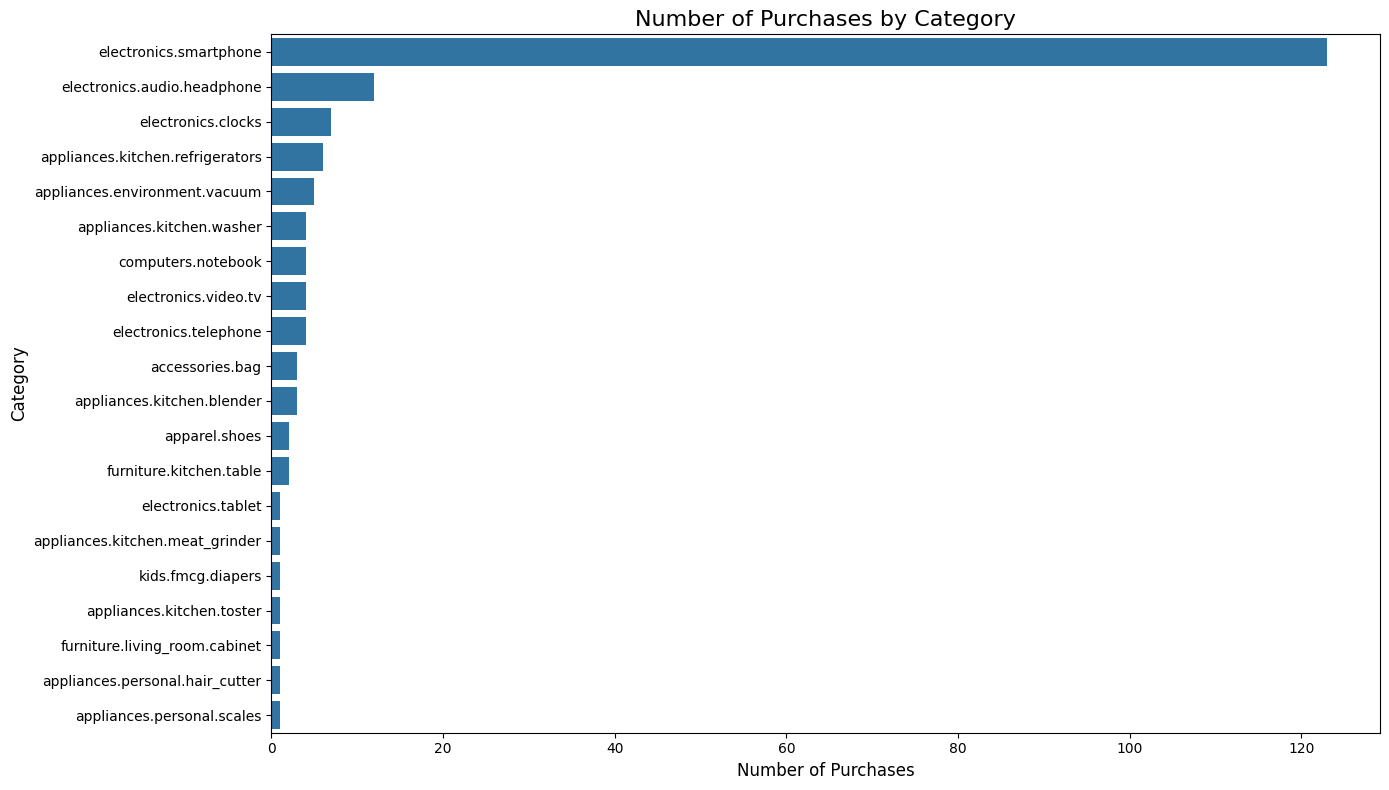

In [ ]:
# Calculate sum of event_type (purchases) per category_code
category_purchase_counts = all_events_df.groupby('category_code')['event_type'].sum().reset_index()
category_purchase_counts = category_purchase_counts.sort_values('event_type', ascending=False)

# Display the top categories by purchase count
print("Top categories by number of purchases:")
print(category_purchase_counts.head(10))

# Create a bar chart showing purchases by category
plt.figure(figsize=(14, 8))
ax = sns.barplot(x='event_type', y='category_code', data=category_purchase_counts.head(20))
plt.title('Number of Purchases by Category', fontsize=16)
plt.xlabel('Number of Purchases', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.tight_layout()
plt.show()

# Alternative: Create an interactive bar chart with Plotly
fig = px.bar(
    category_purchase_counts.head(20), 
    x='event_type', 
    y='category_code',
    title='Number of Purchases by Category',
    labels={'event_type': 'Number of Purchases', 'category_code': 'Category'},
    width=1000,
    height=600
)
fig.update_layout(yaxis={'categoryorder': 'total ascending'})
fig.show()
fig.show()

/tmp/ipykernel_60375/2036899418.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




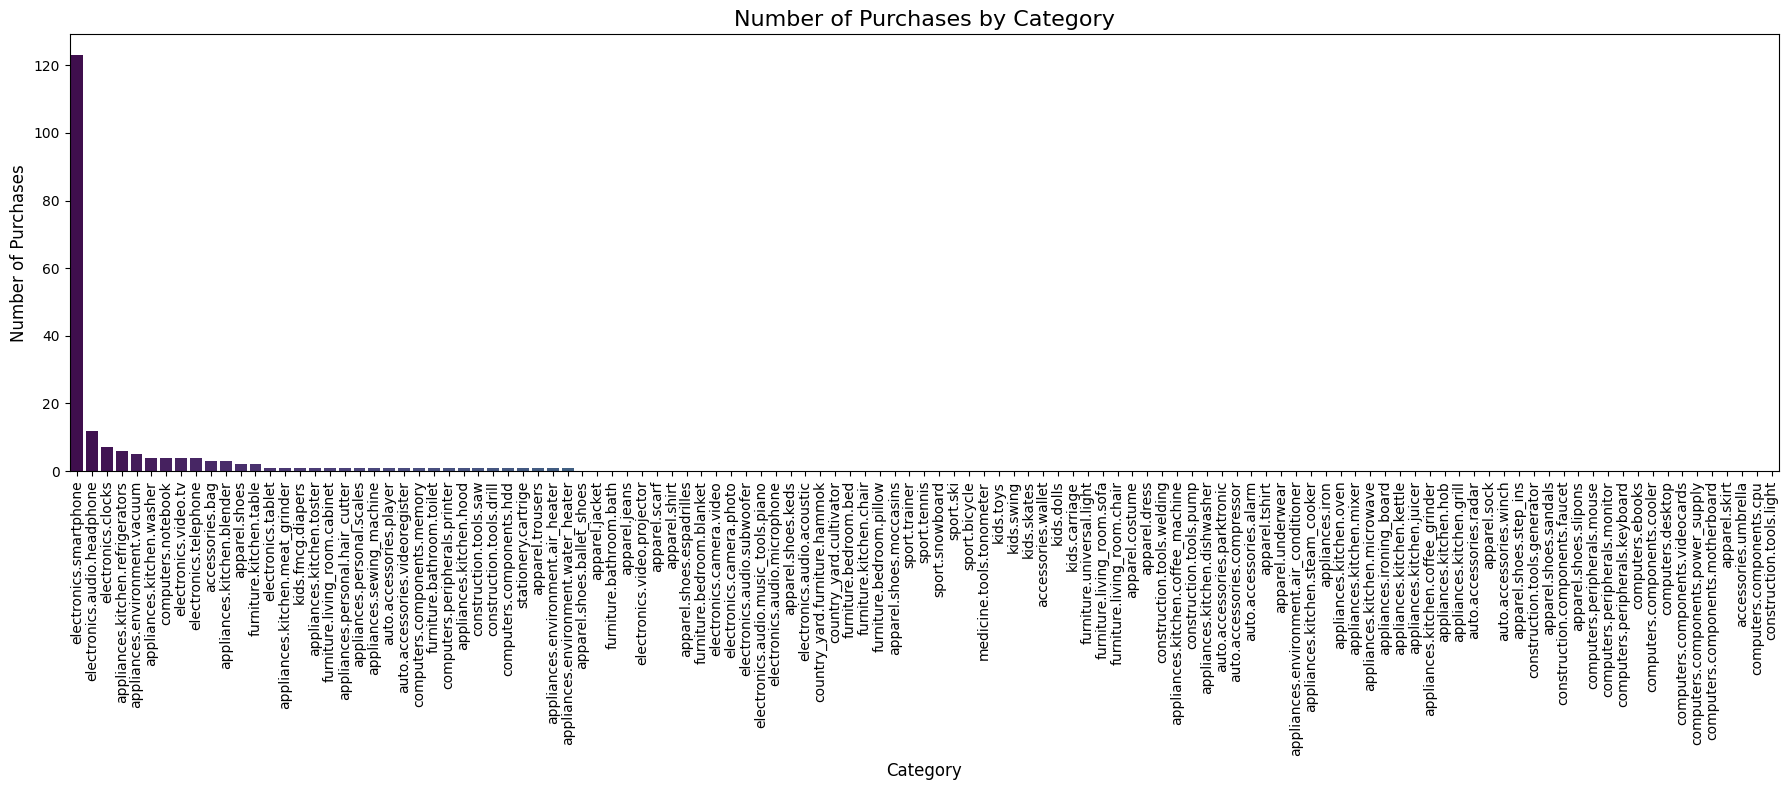

In [ ]:
plt.figure(figsize=(18, 8))
ax = sns.barplot(x='category_code', y='event_type', data=category_purchase_counts, palette='viridis')
plt.title('Number of Purchases by Category', fontsize=16)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Number of Purchases', fontsize=12)
plt.xticks(rotation=90)  # Rotate x labels vertically
plt.tight_layout()
plt.show()

In [ ]:
cf_dataset = all_events_df.copy().groupby(by=['user_id','category_code'], as_index=False).agg({"event_type":"mean"})

cf_dataset.head()

,user_id,category_code,event_type
0,306441847,appliances.kitchen.oven,0.0
1,434894256,computers.notebook,0.0
2,442188017,computers.peripherals.monitor,0.0
3,443779465,electronics.clocks,0.0
4,444990139,electronics.smartphone,0.0


In [ ]:
num_users = len(cf_dataset['user_id'].value_counts())
num_items = len(cf_dataset['category_code'].value_counts())
print('Unique number of product in the dataset: {}'.format(num_users))
print('Unique number of category in the dataset: {}'.format(num_items))


Unique number of product in the dataset: 3591
Unique number of category in the dataset: 115


In [ ]:
purchased_count_df = pd.DataFrame(cf_dataset.groupby(['event_type']).size(), columns=['count'])
purchased_count_df

,count
event_type,
0.000000,3970
0.037037,2
0.041667,1
0.055556,1
0.058824,1
0.062500,2
0.071429,2
0.076923,1
0.083333,2


Text(0, 0.5, 'number of purchase event')

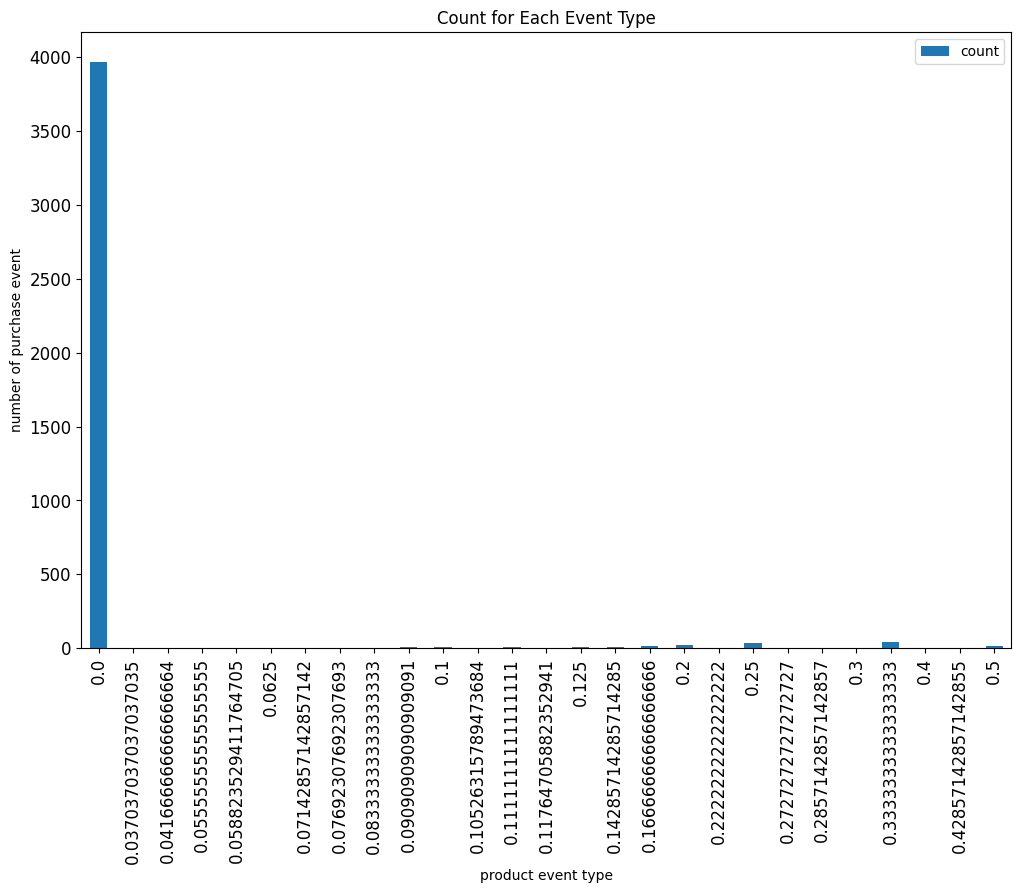

In [ ]:
ax = purchased_count_df.reset_index().rename(columns={'index': 'event_type'}).plot('event_type','count', 'bar',
    figsize=(12, 8),
    title='Count for Each Event Type',
    fontsize=12)

ax.set_xlabel("product event type")
ax.set_ylabel("number of purchase event")

In [ ]:
cf_dataset.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
user_id,4150,3591,512395480,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
category_code,4150,115,electronics.smartphone,1629,NaN,NaN,NaN,NaN,NaN,NaN,NaN
event_type,4150.0,NaN,NaN,NaN,0.010291,0.053761,0.0,0.0,0.0,0.0,0.5


In [ ]:
cf_dataset['event_type'] = cf_dataset['event_type']
cf_dataset['event_type'].value_counts()

event_type
0.000000    3970
0.333333      42
0.250000      36
0.200000      19
0.166667      18
0.500000      12
0.125000       8
0.100000       6
0.111111       6
0.090909       6
0.142857       5
0.222222       2
0.285714       2
0.037037       2
0.062500       2
0.071429       2
0.083333       2
0.041667       1
0.300000       1
0.058824       1
0.272727       1
0.400000       1
0.055556       1
0.076923       1
0.117647       1
0.105263       1
0.428571       1
Name: count, dtype: int64

In [ ]:
cf_dataset['event_type'].values.sum()

42.708055572451855

In [ ]:
cf_dataset.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
user_id,4150,3591,512395480,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
category_code,4150,115,electronics.smartphone,1629,NaN,NaN,NaN,NaN,NaN,NaN,NaN
event_type,4150.0,NaN,NaN,NaN,0.010291,0.053761,0.0,0.0,0.0,0.0,0.5


In [ ]:
# pivot and create product-user matrix
user_to_product_df = cf_dataset.pivot(
    index='user_id',
     columns='category_code',
      values='event_type').fillna(0)

user_to_product_df.head()

category_code,accessories.bag,accessories.umbrella,accessories.wallet,apparel.costume,apparel.dress,apparel.jacket,apparel.jeans,apparel.scarf,apparel.shirt,apparel.shoes,...,kids.skates,kids.swing,kids.toys,medicine.tools.tonometer,sport.bicycle,sport.ski,sport.snowboard,sport.tennis,sport.trainer,stationery.cartrige
user_id,,,,,,,,,,,,,,,,,,,,,
306441847,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
434894256,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
442188017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
443779465,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
444990139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
user_to_product_df.shape

(3591, 115)

In [ ]:
user_to_product_df.values.sum()


42.70805557245186

In [ ]:
user_to_product_df

category_code,accessories.bag,accessories.umbrella,accessories.wallet,apparel.costume,apparel.dress,apparel.jacket,apparel.jeans,apparel.scarf,apparel.shirt,apparel.shoes,...,kids.skates,kids.swing,kids.toys,medicine.tools.tonometer,sport.bicycle,sport.ski,sport.snowboard,sport.tennis,sport.trainer,stationery.cartrige
user_id,,,,,,,,,,,,,,,,,,,,,
306441847,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
434894256,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
442188017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
443779465,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
444990139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555467129,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
555467157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
555467172,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#162     512606538
#308     512913604
#379     513166095

# Create a mapping dictionary from positional index to original user_id
user_index_to_id_map = {}
user_id_to_index_map = {}

# Populate the mapping dictionaries
for i, user_id in enumerate(user_to_product_df.index):
    user_index_to_id_map[i] = user_id  # Maps position to actual user_id
    user_id_to_index_map[user_id] = i  # Maps user_id to position
    
# Create a DataFrame to store these mappings
user_mapping_df = pd.DataFrame({
    'position_index': range(len(user_to_product_df)),
    'user_id': user_to_product_df.index
})

# Display the first few rows of the mapping DataFrame
user_mapping_df.head()

,position_index,user_id
0,0,306441847
1,1,434894256
2,2,442188017
3,3,443779465
4,4,444990139


In [ ]:
user_mapping_df.iloc[162]

position_index          162
user_id           512699625
Name: 162, dtype: object

In [ ]:
count = 0
for index, row in user_to_product_df.iterrows():
    count += 1 
    for col in user_to_product_df.columns:

        if user_to_product_df.loc[index, col] != 0:
            print(count)
            print(index)
            print(f"Column: {col}, Value: {user_to_product_df.loc[index, col]}")


35
512384348
Column: electronics.smartphone, Value: 0.25
44
512416959
Column: appliances.kitchen.refrigerators, Value: 0.2
71
512478069
Column: accessories.bag, Value: 0.10526315789473684
110
512550575
Column: auto.accessories.videoregister, Value: 0.16666666666666666
113
512556357
Column: electronics.smartphone, Value: 0.3333333333333333
126
512584306
Column: appliances.environment.vacuum, Value: 0.2
131
512592316
Column: electronics.smartphone, Value: 0.2222222222222222
142
512607090
Column: electronics.smartphone, Value: 0.2
154
512682014
Column: electronics.smartphone, Value: 0.0625
176
512730342
Column: electronics.smartphone, Value: 0.2857142857142857
177
512736046
Column: electronics.clocks, Value: 0.1
190
512758113
Column: electronics.smartphone, Value: 0.2
202
512778902
Column: stationery.cartrige, Value: 0.125
217
512812487
Column: electronics.smartphone, Value: 0.25
256
512907792
Column: appliances.kitchen.blender, Value: 0.1111111111111111
274
512968794
Column: electronics.

In [ ]:
# transform matrix to scipy sparse matrix
user_to_product_sparse_df = csr_matrix(user_to_product_df.values)
user_to_product_sparse_df

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 180 stored elements and shape (3591, 115)>

In [ ]:
user_to_product_sparse_df.get_shape()

(3591, 115)

In [ ]:
user_to_product_sparse_df.nnz

180

In [ ]:
user_to_product_sparse_df.size

180

In [ ]:
user_to_product_sparse_df.data

array([0.25      , 0.2       , 0.10526316, 0.16666667, 0.33333333,
       0.2       , 0.22222222, 0.2       , 0.0625    , 0.28571429,
       0.1       , 0.2       , 0.125     , 0.25      , 0.11111111,
       0.25      , 0.03703704, 0.2       , 0.33333333, 0.5       ,
       0.2       , 0.11764706, 0.5       , 0.2       , 0.16666667,
       0.14285714, 0.125     , 0.16666667, 0.16666667, 0.25      ,
       0.0625    , 0.4       , 0.16666667, 0.25      , 0.25      ,
       0.07692308, 0.25      , 0.33333333, 0.25      , 0.125     ,
       0.33333333, 0.1       , 0.09090909, 0.11111111, 0.33333333,
       0.09090909, 0.25      , 0.33333333, 0.16666667, 0.33333333,
       0.14285714, 0.33333333, 0.33333333, 0.33333333, 0.25      ,
       0.33333333, 0.08333333, 0.14285714, 0.25      , 0.33333333,
       0.125     , 0.5       , 0.25      , 0.25      , 0.16666667,
       0.16666667, 0.1       , 0.33333333, 0.33333333, 0.05555556,
       0.04166667, 0.33333333, 0.25      , 0.25      , 0.33333

**Fitting K-Nearest Neighbours model to the scipy sparse matrix:**

In [ ]:
knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
knn_model.fit(user_to_product_sparse_df)

NearestNeighbors(algorithm='brute', metric='cosine')

In [ ]:
## function to find top n similar users of the given input user 
def get_similar_users(user, n = 5):
  ## input to this function is the user and number of top similar users you want.

  knn_input = np.asarray([user_to_product_df.values[user-1]])  #.reshape(1,-1)
  # knn_input = user_to_movie_df.iloc[0,:].values.reshape(1,-1)
  distances, indices = knn_model.kneighbors(knn_input, n_neighbors=n+1)
  
  print("Top",n,"users who are very much similar to the User-",user, " Real ID : " + user_mapping_df.iloc[user]['user_id'] + " are: ")
  print(" ")
  for i in range(1,len(distances[0])):
    print(i,". User:", indices[0][i]+1, "separated by distance of",distances[0][i])
  return indices.flatten()[1:] + 1, distances.flatten()[1:]



In [ ]:
cf_dataset[cf_dataset['user_id'] == 35]['category_code']

Series([], Name: category_code, dtype: object)

In [ ]:
user_mapping_df.iloc[35]["user_id"]

'512384407'

In [ ]:
# Example usage:
user_id =  35 # This is the actual user ID, not position index

# Get similar users
similar_user_ids, distances = get_similar_users(user_id, 5)
user_categories = cf_dataset[cf_dataset['user_id'] == similar_user_id]['category_code']
from pprint import pprint
user_id = 778
print(" Few of Category seen by the User:")
print(user_categories)[:10]
similar_user_list, distance_list = get_similar_users(user_id,5)

Top 5 users who are very much similar to the User- 35  Real ID : 512384407 are: 
 
1 . User: 2279 separated by distance of 0.0
2 . User: 3451 separated by distance of 0.0
3 . User: 154 separated by distance of 0.0
4 . User: 1956 separated by distance of 0.0
5 . User: 3460 separated by distance of 0.0
 Few of Category seen by the User:
2776    electronics.smartphone
Name: category_code, dtype: object


TypeError: 'NoneType' object is not subscriptable

In [ ]:
similar_user_list, distance_list

NameError: name 'similar_user_list' is not defined

In [ ]:
weightage_list = distance_list/np.sum(distance_list)
weightage_list

array([0.2, 0.2, 0.2, 0.2, 0.2])

In [ ]:
cat_event_type_sim_users = user_to_product_df.loc[similar_user_list].values
cat_event_type_sim_users

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [ ]:
cat_event_type_sim_users.shape

(5, 115)

In [ ]:
cat_list = user_to_product_df.columns
cat_list

Index(['accessories.bag', 'accessories.umbrella', 'accessories.wallet',
       'apparel.costume', 'apparel.dress', 'apparel.jacket', 'apparel.jeans',
       'apparel.scarf', 'apparel.shirt', 'apparel.shoes',
       ...
       'kids.skates', 'kids.swing', 'kids.toys', 'medicine.tools.tonometer',
       'sport.bicycle', 'sport.ski', 'sport.snowboard', 'sport.tennis',
       'sport.trainer', 'stationery.cartrige'],
      dtype='object', name='category_code', length=115)

In [ ]:
print("Weightage list shape:", len(weightage_list))
print("cat_event_type_sim_users shape:", cat_event_type_sim_users.shape)
print("Number of categories:", len(cat_list))

Weightage list shape: 5
cat_event_type_sim_users shape: (5, 115)
Number of categories: 115


**Broadcasting weightage matrix to similar user matrix. so that it gets compatible for matrix operations**

In [ ]:
weightage_list = weightage_list[:,np.newaxis] + np.zeros(len(cat_list))
weightage_list.shape

(5, 115)

In [ ]:
new_event_type_matrix = weightage_list*cat_event_type_sim_users
event_type_list = new_event_type_matrix.sum(axis =0)
event_type_list

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
from pprint import pprint
def recommend_category(n):
  n = min(len(event_type_list),n)
  # print(np.argsort(mean_rating_list)[::-1][:n])
  pprint(list(cat_list[np.argsort(event_type_list)[::-1][:n]]))



In [ ]:
print("Categories recommended based on similar users are: ")
recommend_category(10)

Categories recommended based on similar users are: 
['stationery.cartrige',
 'appliances.kitchen.blender',
 'appliances.kitchen.coffee_machine',
 'appliances.kitchen.dishwasher',
 'appliances.kitchen.grill',
 'appliances.kitchen.hob',
 'appliances.kitchen.hood',
 'appliances.kitchen.juicer',
 'appliances.kitchen.kettle',
 'appliances.kitchen.meat_grinder']


It had been observed that, this recommendation system built can be made more efficient as it has few drawbacks.

**Drawbacks:**

**1.** But this recommendation system has a drawback, it also **recommends movies which are already seen by the given input User.**

**2.** And also there is a possibility of recommending the **movies which are not at all seen by any of the similar users.**

In [ ]:
def filtered_category_recommendations(user_id, n=10):
    """
    Recommend categories to a user that they haven't seen before,
    based on similar users' preferences
    
    Parameters:
    user_id: The actual user ID (not position index)
    n: Maximum number of recommendations to return
    
    Returns:
    final_category_list: List of recommended categories
    """
    # Make sure we're using the correct user_id by converting if needed
    if isinstance(user_id, int) and user_id not in user_id_to_index_map:
        # If user provided a position index instead of actual user_id
        if user_id < len(user_index_to_id_map):
            actual_user_id = user_index_to_id_map[user_id]
        else:
            print(f"Error: Position index {user_id} is out of bounds.")
            return []
    else:
        # User provided an actual user_id
        actual_user_id = user_id
    
    # Get similar users for this user
    similar_user_ids, distances = get_similar_users(user_id, 5)
    
    # Calculate weighted event types as you were doing before
    weightage_list = distances/np.sum(distances)
    weightage_list = weightage_list[:,np.newaxis] + np.zeros(len(cat_list))
    
    # Get categories from similar users
    cat_event_type_sim_users = user_to_product_df.loc[similar_user_ids].values
    new_event_type_matrix = weightage_list*cat_event_type_sim_users
    event_type_list = new_event_type_matrix.sum(axis=0)
    
    # Filter for non-zero scores and sort
    first_zero_index = np.where(event_type_list == 0)[0][-1] if 0 in event_type_list else len(event_type_list)
    sortd_index = np.argsort(event_type_list)[::-1]
    sortd_index = sortd_index[:list(sortd_index).index(first_zero_index)] if first_zero_index in sortd_index else sortd_index
    
    # Get the list of categories the user has already seen
    categories_seen = list(cf_dataset[cf_dataset['user_id'] == actual_user_id]['category_code'])
    
    # Filter out categories the user has already seen
    filtered_category_list = list(cat_list[sortd_index])
    final_category_list = []
    count = 0
    
    for category in filtered_category_list:
        if category not in categories_seen:
            count += 1
            final_category_list.append(category)
        if count == n:
            break
    
    if count == 0:
        print(f"No new categories to recommend for user {actual_user_id}.")
    else:
        print(f"Recommending {count} new categories for user {actual_user_id}:")
        pprint(final_category_list)
    
    return final_category_list

In [ ]:
filtered_category_recommendations()

#162     512606538
#308     512913604

NameError: name 'filtered_category_recommendations' is not defined

In [ ]:
con.close()

NameError: name 'con' is not defined